<a href="https://colab.research.google.com/github/kwanderer/Autonomas-sistemas-un-roboti/blob/main/model_1_from_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
import seaborn as sns 
%matplotlib inline

In [27]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/data_binary/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
df = pd.read_csv("binary_data_csv.csv")

In [29]:
df.head()

,tachometer,und-accelerometer-axial,und-accelerometer-radial,und-accelerometer-tangential,over-accelerometer-axial,over-accelerometer-radial,over-accelerometer-tangential,microphone,Class
0,4.5051,-1.542900,-0.36705,-0.082564,-2.5684,0.077869,-0.80149,0.15873,1
1,4.4602,0.824310,0.34692,0.053980,-2.4641,0.075809,-0.71191,-0.11093,1
2,4.5097,-1.091100,-0.34990,-0.047315,-2.5442,0.073877,-0.78388,0.19010,1
3,4.4614,0.043019,0.23206,0.062850,-2.5026,0.073081,-0.73637,-0.10022,1
4,4.5006,-0.085942,-0.13515,0.019958,-2.5031,0.072786,-0.72987,0.16343,1


In [30]:
print('This data frame has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

This data frame has 12500000 rows and 9 columns.


In [31]:
#count of fraud vs. normal transactions 

counts = df.Class.value_counts()
normal = counts[0]
imbalance = counts[1]
perc_normal = (normal/(normal+imbalance))*100
perc_imbalance = (imbalance/(normal+imbalance))*100
print('There were {} normal data ({:.3f}%) and {} imbalance transactions ({:.3f}%).'.format(normal, perc_normal, imbalance, perc_imbalance))

There were 5000000 normal data (40.000%) and 7500000 imbalance transactions (60.000%).


Text(0.5, 0, 'Class (0:Normal, 1:Imbalance)')

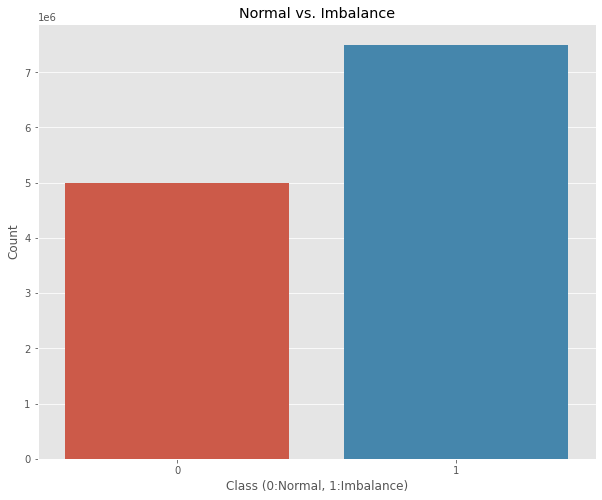

In [32]:
plt.figure(figsize=(10,8))
sns.barplot(x=counts.index, y=counts)
plt.title('Normal vs. Imbalance')
plt.ylabel('Count')
plt.xlabel('Class (0:Normal, 1:Imbalance)')

Text(0.5, 1.0, 'Heatmap of Correlation')

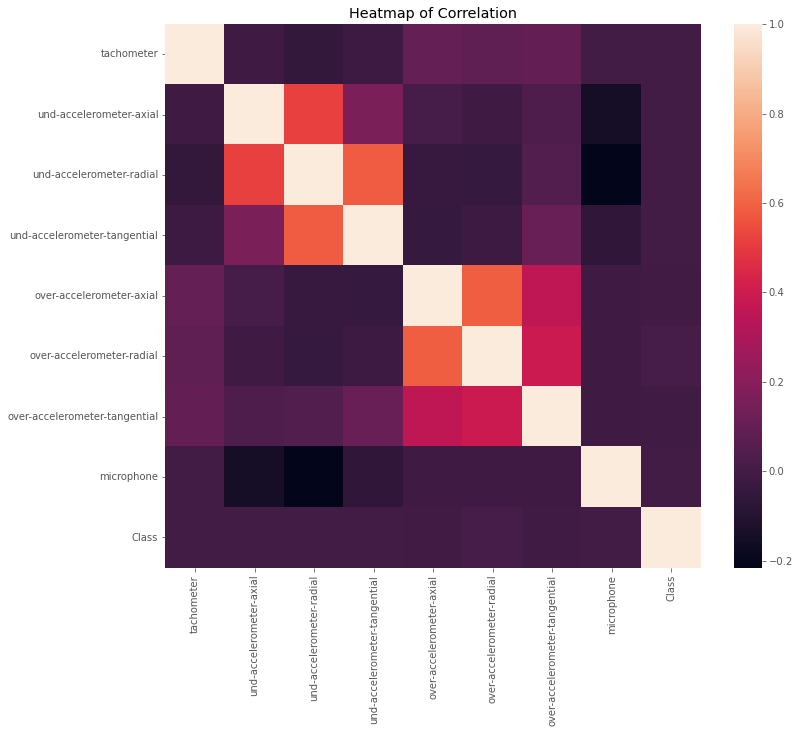

In [33]:
#finding correlation between columns and plotting heatmap

corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Heatmap of Correlation')

In [34]:
df.isnull().sum()

tachometer                       0
und-accelerometer-axial          0
und-accelerometer-radial         0
und-accelerometer-tangential     0
over-accelerometer-axial         0
over-accelerometer-radial        0
over-accelerometer-tangential    0
microphone                       0
Class                            0
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500000 entries, 0 to 12499999
Data columns (total 9 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   tachometer                     float64
 1   und-accelerometer-axial        float64
 2   und-accelerometer-radial       float64
 3   und-accelerometer-tangential   float64
 4   over-accelerometer-axial       float64
 5   over-accelerometer-radial      float64
 6   over-accelerometer-tangential  float64
 7   microphone                     float64
 8   Class                          int64  
dtypes: float64(8), int64(1)
memory usage: 858.3 MB


In [36]:
data=df.copy()

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500000 entries, 0 to 12499999
Data columns (total 9 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   tachometer                     float64
 1   und-accelerometer-axial        float64
 2   und-accelerometer-radial       float64
 3   und-accelerometer-tangential   float64
 4   over-accelerometer-axial       float64
 5   over-accelerometer-radial      float64
 6   over-accelerometer-tangential  float64
 7   microphone                     float64
 8   Class                          int64  
dtypes: float64(8), int64(1)
memory usage: 858.3 MB


**Model-1(Over Sampling)**

In [38]:
# Create two different dataframes of majority and minority class 
df_fraud = data[data.Class==1]
df_non_fraud = data[data.Class==0]

# Oversample the minority class
from sklearn.utils import resample
df_fraud_oversampled = resample(df_fraud, 
                                 replace=True,    # sample with replacement
                                 n_samples=len(df_non_fraud) , # to match majority class with len(df_majority) rows
                                 random_state=42)  # reproducible results

# Combine majority class with oversampled minority class
df_oversampled = pd.concat([df_fraud_oversampled, df_non_fraud])

In [39]:
df_oversampled.Class.value_counts()

1    5000000
0    5000000
Name: Class, dtype: int64

[Text(0, 0, 'Normal'), Text(0, 0, 'Imbalance')]

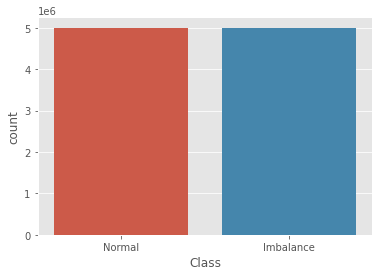

In [40]:
g = sns.countplot(df_oversampled.Class)
g.set_xticklabels(['Normal','Imbalance'])

In [41]:
# Target y and features X for developing NN models
y = df_oversampled.Class
X = df_oversampled.drop(['Class'], axis=1)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, roc_auc_score

In [43]:
# split the data (X, y) to train-data and test-data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=101)

In [44]:
X_train.shape, X_test.shape

((7000000, 8), (3000000, 8))

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [47]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [48]:
X_train.shape, X_test.shape

((7000000, 8, 1), (3000000, 8, 1))

In [49]:
epochs=20
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train[0].shape),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D((1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 6, 32)             128       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 4, 64)             6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 64)             12352     
                                                                 
 flatten_1 (Flatten)         (None, 128)              

In [50]:
# Compile the model as usual
model_cnn.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [51]:
# Train the model
history = model_cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
218750/218750 [==============================] - 1311s 6ms/step - loss: 0.2920 - accuracy: 0.8808 - val_loss: 0.2818 - val_accuracy: 0.8838
Epoch 2/10
218750/218750 [==============================] - 1275s 6ms/step - loss: 0.3001 - accuracy: 0.8812 - val_loss: 0.2989 - val_accuracy: 0.8853
Epoch 3/10
218750/218750 [==============================] - 1353s 6ms/step - loss: 0.3157 - accuracy: 0.8779 - val_loss: 0.3094 - val_accuracy: 0.8810
Epoch 4/10
218750/218750 [==============================] - 1288s 6ms/step - loss: 0.3386 - accuracy: 0.8737 - val_loss: 0.3819 - val_accuracy: 0.8739
Epoch 5/10
218750/218750 [==============================] - 1413s 6ms/step - loss: 0.3320 - accuracy: 0.8723 - val_loss: 0.2986 - val_accuracy: 0.8822
Epoch 6/10
218750/218750 [==============================] - 1560s 7ms/step - loss: 0.3418 - accuracy: 0.8681 - val_loss: 0.3446 - val_accuracy: 0.8730
Epoch 7/10
218750/218750 [==============================] - 1209s 6ms/step - loss: 0.3530 - ac

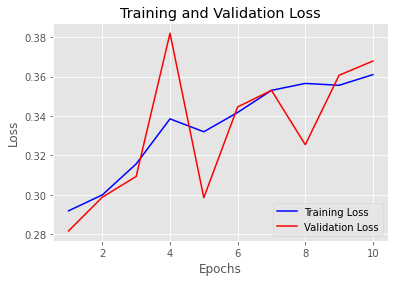

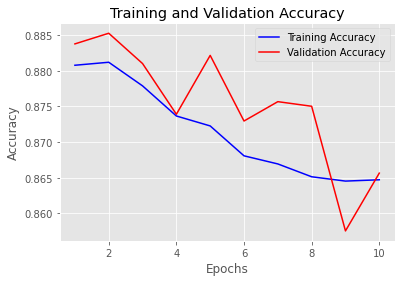

In [52]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('cnn_loss_plot.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cnn_acc_plot.png')
plt.show()

In [53]:
val_predictions = model_cnn.predict(X_test)
pred=np.around(val_predictions)
pred

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [54]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88   1500000
           1       0.95      0.77      0.85   1500000

    accuracy                           0.87   3000000
   macro avg       0.88      0.87      0.86   3000000
weighted avg       0.88      0.87      0.86   3000000



**Model 2-MAX pooling**

In [55]:
scaler = StandardScaler()
df['NormalizedAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

KeyError: ignored

In [ ]:
y = df['Class']
X = df.drop(['Class'], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

In [ ]:
epochs = 20
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [ ]:
plot_learningCurve(history, epochs)

In [ ]:
val_predictions = model.predict(X_test)
pred=np.around(val_predictions)
pred

In [ ]:
print(classification_report(y_test, pred))

**Model 3- DNN Weighted Neural Network**

****

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
train_data, test_data, train_targets, test_targets = train_test_split(X, y, test_size=.3)

In [ ]:
train_data, validation_data, train_targets, validation_targets = train_test_split(train_data, train_targets, test_size=.2)

In [ ]:
mean = np.mean(train_data)
std = np.std(train_data)


train_data -= mean
train_data /= std

validation_data -= mean
validation_data /= std

test_data -= mean
test_data /= std

In [ ]:
from keras import models, layers

In [ ]:
epochs=20
model = models.Sequential()

model.add(layers.Dense(10, input_shape=(train_data.shape[1],), activation='relu'))

model.add(layers.Dense(8, activation='relu'))

model.add(layers.Dense(6, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_data, train_targets, epochs=epochs, validation_data=(test_data, test_targets), verbose=1)

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [ ]:
plot_learningCurve(history, epochs)

In [ ]:
val_predictions = model.predict(test_data)
pred=np.around(val_predictions)
pred

In [ ]:
print(classification_report(test_targets, pred))

In [ ]:
train_targets.value_counts()

There are 278 1's (frauds) and 159213 0's (non-frauds)

159213/278 = 572.7

0's are 572.7 times more than 1's

We can assign custom weights to NN accordingly

In [ ]:
weights = {
    0:1,
    1:562
}

In [ ]:
model = models.Sequential()

model.add(layers.Dense(10, input_shape=(train_data.shape[1],), activation='relu'))

model.add(layers.Dense(8, activation='relu'))

model.add(layers.Dense(6, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

# CHANGE
history = model.fit(train_data, train_targets, epochs=epochs, validation_data=(test_data, test_targets), verbose=1, class_weight=weights)

In [ ]:
plot_learningCurve(history, epochs)

In [ ]:
score = model.evaluate(test_data, test_targets, batch_size=100)
print('\nAnd the Score is ', score[1] * 100, '%')

In [ ]:
predictions = model.predict(test_data)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_targets, predictions)

In [ ]:
predictions = np.around(predictions)

In [ ]:
print(classification_report(test_targets, predictions))

**LSTM**

In [ ]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
from keras import backend as K, regularizers, Model, metrics
from keras.backend import cast

In [ ]:
data = pd.read_csv("../input/creditcardfraud/creditcard.csv")
col_del = ['Time' ,'V5', 'V6', 'V7', 'V8', 'V9','V13','V15', 'V16',  'V18', 'V19', 'V20','V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [ ]:
tr_data = data.drop(col_del,axis =1)
tr_data.shape

In [ ]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [ ]:
# Generate and plot imbalanced classification dataset
from collections import Counter
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(tr_data['Class'])
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(tr_data['Class'] == label)[0]

In [ ]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_r, y = oversample.fit_resample(X, tr_data['Class'])
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]

In [ ]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X_r2 = StandardScaler().fit_transform(X_r)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_r2, y, test_size=0.3)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
# design network
np.random.seed(7)

# X_train et X_val sont des dataframe qui contient les features
train_LSTM_X=X_train
val_LSTM_X=X_test

## Reshape input to be 3D [samples, timesteps, features] (format requis par LSTM)
train_LSTM_X = train_LSTM_X.reshape((train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
val_LSTM_X = val_LSTM_X.reshape((val_LSTM_X.shape[0], 1, val_LSTM_X.shape[1]))

## Recuperation des labels
train_LSTM_y=y_train
val_LSTM_y=y_test

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
inputs1=Input((1,9))
att_in=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(inputs1)
att_in_1=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
att_out=attention()(att_in_1)
outputs1=Dense(1,activation='sigmoid',trainable=True)(att_out)
model1=Model(inputs1,outputs1)

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=model1.fit(train_LSTM_X, train_LSTM_y,epochs=20,batch_size=20000, validation_data=(val_LSTM_X, val_LSTM_y))

In [ ]:
# evaluate the model
_, train_acc = model1.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model1.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()